In [53]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Data augmentation is a key technique used in computer vision. It helps neural networks to learn useful representations and generalize better to unseen samples. In this tutorial we show how to do data augmentation in Pytorch EO. We provide default integration with `albumentations`.

In [54]:
from pytorch_eo.datasets.eurosat import EuroSATRGB

ds = EuroSATRGB() # no transform
ds.setup()

If no transforms are provided to the dataset, images will always be loaded in the same way.

In [55]:
import matplotlib.pyplot as plt

def plot_sample(ds, ix):
    fig = plt.figure(figsize=(10, 10))
    for i in range(5):
        img, label = ds.ds[ix]
        ax = plt.subplot(1, 5, i + 1)
        ax.imshow(img)
        ax.set_title(ds.classes[label])
        ax.axis('off')
    plt.tight_layout()
    plt.show()

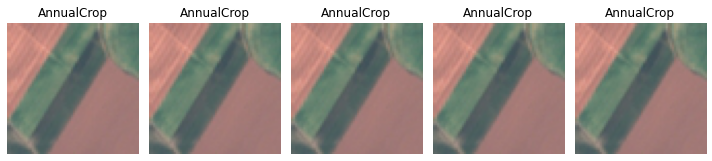

In [56]:
plot_sample(ds, 0)

By providing transforms, we can have more variety in our data.

In [57]:
import albumentations as A

trans = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5)
])

ds = EuroSATRGB(trans=trans)
ds.setup()

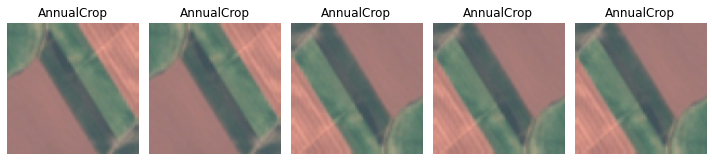

In [58]:
plot_sample(ds, 0)

Torchvision transforms can run in batch mode in the gpu (which can be faster). To do so, put the transforms in your model. The same transform is applied to all the batch. 

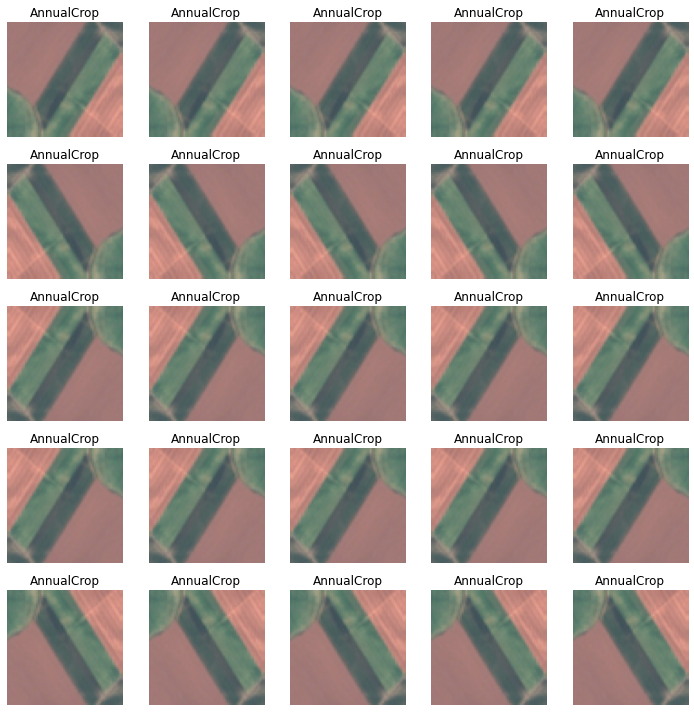

In [59]:
import torch
from torchvision.transforms import RandomHorizontalFlip, RandomVerticalFlip
from einops import rearrange

trans = torch.nn.Sequential(
    RandomHorizontalFlip(p=0.5),
    RandomVerticalFlip(p=0.5),
)

# create a batch with the same image
img, label = ds.ds[0]
imgs = rearrange(torch.stack(5*[torch.from_numpy(img)]), 'b h w c -> b c h w')

rounds = 5
fig = plt.figure(figsize=(10,rounds*2))
for r in range(rounds):
    output = trans(imgs) 
    for i, img in enumerate(output):
        ax = plt.subplot(rounds, 5, r*5 + i + 1)
        ax.imshow(img.permute(1,2,0))
        ax.set_title(ds.classes[label])
        ax.axis('off')
plt.tight_layout()
plt.show()

## Other tasks

Torchvision support for augmenting bounding boxes, segmentation masks, keypoints, ... is limited. For that, `albumentations` is a great alternative.

In [60]:
# TODO: examples